In [1]:
import numpy as np
import pandas as pd
from numpy import pi
from numpy.linalg import inv
import qiskit
from qiskit import execute, Aer
from qiskit.visualization import plot_histogram
from qiskit.tools.visualization import plot_state_city, plot_bloch_multivector
from qiskit.tools.monitor import job_monitor
from qiskit.quantum_info import state_fidelity
from qiskit.quantum_info import DensityMatrix
from qiskit.quantum_info.random.utils import random_state
from random import randint
from qiskit.providers.aer import noise
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer
%config InlineBackend.figure_format = 'svg' # Makes the images look nice
from qiskit.quantum_info.operators import Operator, Pauli

# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
import qiskit.ignis.mitigation.measurement as mc
# imports IBMQ backends
from qiskit.providers.ibmq import IBMQ
ibmq_provider = IBMQ.load_account()        # credentials stored on disk
simulator = ibmq_provider.get_backend('ibmq_qasm_simulator')
device = ibmq_provider.get_backend('ibmqx2') #ibmq_burlington ibmq_16_melbourne ibmqx2
backend_IBMQ = ibmq_provider.get_backend('ibmqx2')
properties = backend_IBMQ.properties()
noise_model = noise.device.basic_device_noise_model(properties)
coupling_map = backend_IBMQ.configuration().coupling_map
basis_gates = noise_model.basis_gates

C:\Users\Niels\Envs\dev_qiskit\lib\site-packages\qiskit\providers\aer\noise\device\basic_device_model.py:112: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0. -1.]]


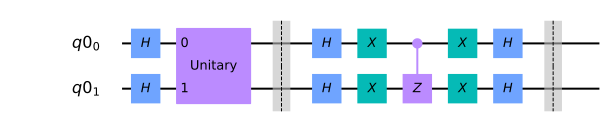

In [2]:
dim = 2
z= QuantumRegister(dim)
qc_expected = QuantumCircuit(z)
qc_expected.h(range(dim))
qreg = QuantumCircuit(z)
# creating a randomized Grover operator
a = randint(0,2**dim-1)
A = np.identity(2**dim)
A[a,a] = -1
print(A)
Grov = Operator(A)
qc_expected.append(Grov,range(dim))

qc_expected.barrier()
qc_expected.h(range(dim))
qc_expected.x(range(dim))

qc_expected.cz(0,1)
qc_expected.x(range(dim))
qc_expected.h(range(dim))
qc_expected.barrier()
qc_expected.draw(output='mpl')

The expected state is: [ 7.49879891e-33+0.0000000e+00j  0.00000000e+00-1.2246468e-16j
 -7.49879891e-33-1.2246468e-16j -1.00000000e+00+2.4492936e-16j]


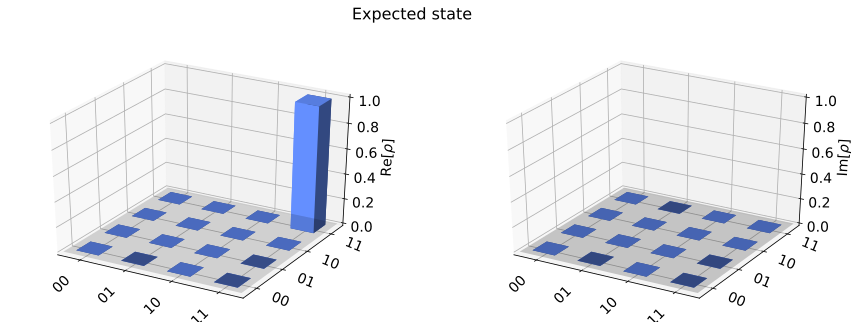

In [3]:
job = qiskit.execute(qc_expected, Aer.get_backend('statevector_simulator'))
psi_expected = job.result().get_statevector(qc_expected)
print('The expected state is:', psi_expected)
plot_state_city(psi_expected, title='Expected state')

In [4]:
#mitigation measurement
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)
cal_circuits, state_labels = complete_meas_cal(qr = qc_expected.qregs[0], circlabel = 'measerrormitcal')
cal_job = execute(cal_circuits,backend = device,shots = 8192,optimization_level = 0,)
job_monitor(cal_job)
calres = cal_job.result()

Job Status: job has successfully run


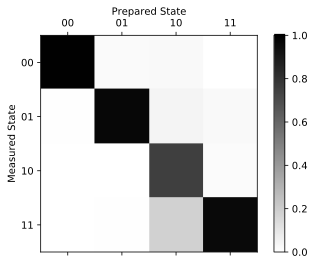

[array([0.11297607, 0.86590576, 0.10748291]), array([ 0.9487915 ,  0.02203369, -0.02056885]), array([-0.07348633,  0.10571289,  0.859375  ])]
[-0.09613037109375, 0.04046630859375, 0.0927734375]


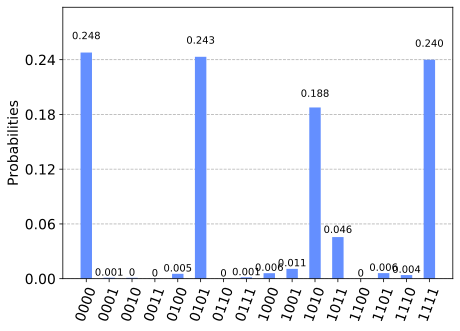

In [5]:
meas_fitter = CompleteMeasFitter(calres, state_labels)
meas_fitter.plot_calibration()
meas_filter = meas_fitter.filter
counts =[0,0,0,0]
bits = ['00', '10', '01', '11']
for i in range(0,4):
    counts[i]=calres.get_counts(cal_circuits[i])
    for bit in bits:
        if bit not in counts[i]:
            counts[i][bit] = 0
countsdev = {'0000':counts[0]['00'],'0001':counts[0]['01'],'0010':counts[0]['10'],'0011':counts[0]['11'],
             '0100':counts[1]['00'],'0101':counts[1]['01'],'0110':counts[1]['10'],'0111':counts[1]['11'],
             '1000':counts[2]['00'],'1001':counts[2]['01'],'1010':counts[2]['10'],'1011':counts[2]['11'],
             '1100':counts[3]['00'],'1101':counts[3]['01'],'1110':counts[3]['10'],'1111':counts[3]['11']}

mX=np.zeros((3, 4))
M=np.array([[1,1,1,1],[1,1,-1,-1],[1,-1,1,-1],[1,-1,-1,1]])
b=[0,0,0]
b0=[0,0,0]
countsnew = {'00':0,'01':0,'10':0,'11':0}
for i in range(4):
    mX[0,i]= (counts[i]["00"]*1 + counts[i]["01"]*(-1)+counts[i]["10"]*(1)+counts[i]["11"]*(-1))/(counts[i]["00"]+counts[i]["01"]+counts[i]["10"]+counts[i]["11"])
    mX[1,i]= (counts[i]["00"]*1 + counts[i]["01"]*(1)+counts[i]["10"]*(-1)+counts[i]["11"]*(-1))/(counts[i]["00"]+counts[i]["01"]+counts[i]["10"]+counts[i]["11"])
    mX[2,i]= (counts[i]["00"]*1 + counts[i]["01"]*(-1)+counts[i]["10"]*(-1)+counts[i]["11"]*(1))/(counts[i]["00"]+counts[i]["01"]+counts[i]["10"]+counts[i]["11"])
for i in range(3):
    beta=np.dot(inv(M),np.array([mX[i,0],mX[i,1],mX[i,2],mX[i,3]]))
    b[i]=beta[1:]
    b0[i]=beta[0]
print(b)
print(b0)
plot_histogram(countsdev)

In [6]:
backends = [simulator, device,0]
paulis = [('X','X'),('Y','X'),('Z','X'),
          ('X','Y'),('Y','Y'),('Z','Y'),
          ('X','Z'),('Y','Z'),('Z','Z')]
basis = ['XX','YX','ZX','XY','YY','ZY','XZ','YZ','ZZ']
x=0
for be in backends:
    state ={}
    for bas in basis:
        state.update({bas: {'00': 0, '10': 0,'01': 0, '11': 0}})
    qst_circuit = state_tomography_circuits(qc_expected,z)
    if be == device or be == simulator:
        job = qiskit.execute(qst_circuit, be, shots=8192)
    print('Done job.')
    if be == device or be == simulator:
        job_monitor(job)
    if be == 0:
        tom = StateTomographyFitter(meas_filter.apply(job.result()),qst_circuit)
    else:
        tom = StateTomographyFitter(job.result(), qst_circuit)
    for pauli in paulis:
        for bit in bits:
            if bit not in tom.data[pauli]:
                tom.data[pauli][bit]=0
    for y,bas in enumerate(basis):
        state.update({bas: {'00': state[bas]['00']+tom.data[paulis[y]][bits[0]],
                                '10': state[bas]['10']+tom.data[paulis[y]][bits[1]],
                                '01': state[bas]['01']+tom.data[paulis[y]][bits[2]],
                                '11': state[bas]['11']+tom.data[paulis[y]][bits[3]]}})
    if be == simulator:
        state_sim = state
        print('The full state for simulator is', state)
    if be == device:
        state_dev = state
        print('The full state for device is', state)
    if be == 0:
        state_err = state
        print('The corrected state for device is', state)

Done job.
Job Status: job has successfully run
The full state for simulator is {'XX': {'00': 2023, '10': 2054, '01': 2066, '11': 2049}, 'YX': {'00': 2107, '10': 1956, '01': 2051, '11': 2078}, 'ZX': {'00': 0, '10': 0, '01': 4092, '11': 4100}, 'XY': {'00': 2058, '10': 2004, '01': 2085, '11': 2045}, 'YY': {'00': 2011, '10': 2054, '01': 2017, '11': 2110}, 'ZY': {'00': 0, '10': 0, '01': 4072, '11': 4120}, 'XZ': {'00': 0, '10': 4124, '01': 0, '11': 4068}, 'YZ': {'00': 0, '10': 4133, '01': 0, '11': 4059}, 'ZZ': {'00': 0, '10': 0, '01': 0, '11': 8192}}
Done job.
Job Status: job has successfully run
The full state for device is {'XX': {'00': 2112, '10': 1761, '01': 1875, '11': 2444}, 'YX': {'00': 2110, '10': 1930, '01': 1923, '11': 2229}, 'ZX': {'00': 151, '10': 126, '01': 3792, '11': 4123}, 'XY': {'00': 2203, '10': 1691, '01': 2151, '11': 2147}, 'YY': {'00': 2221, '10': 1845, '01': 2053, '11': 2073}, 'ZY': {'00': 143, '10': 112, '01': 4097, '11': 3840}, 'XZ': {'00': 185, '10': 3205, '01': 340,

In [7]:
# fidelity processing for sim and dev
XXPaul = np.matrix('0,0,0,1;0,0,1,0;0,1,0,0;1,0,0,0')
XYPaul = np.matrix('0,0,0,0-1j;0,0,0+1j,0;0,0-1j,0,0;0+1j,0,0,0')
XZPaul = np.matrix('0,0,1,0;0,0,0,-1;1,0,0,0;0,-1,0,0')
Iden = np.matrix('1,0,0,0;0,1,0,0;0,0,1,0;0,0,0,1')
YXPaul = np.matrix('0,0,0,0-1j;0,0,0-1j,0;0,0+1j,0,0;0+1j,0,0,0')
YYPaul = np.matrix('0,0,0,-1;0,0,1,0;0,1,0,0;-1,0,0,0')
YZPaul = np.matrix('0,0,0-1j,0;0,0,0,0+1j;0+1j,0,0,0;0,0-1j,0,0')
ZXPaul = np.matrix('0,1,0,0;1,0,0,0;0,0,0,-1;0,0,-1,0')
ZYPaul = np.matrix('0,0-1j,0,0;0+1j,0,0,0;0,0,0,0+1j;0,0,0-1j,0')
ZZPaul = np.matrix('1,0,0,0;0,-1,0,0;0,0,-1,0;0,0,0,1')
IXPaul = np.matrix('0,1,0,0;1,0,0,0;0,0,0,1;0,0,1,0')
IYPaul = np.matrix('0,0-1j,0,0;0+1j,0,0,0;0,0,0,0-1j;0,0,0+1j,0')
IZPaul = np.matrix('1,0,0,0;0,-1,0,0;0,0,1,0;0,0,0,-1')
XIPaul = np.matrix('0,0,1,0;0,0,0,1;1,0,0,0;0,1,0,0')
YIPaul = np.matrix('0,0,0-1j,0;0,0,0,0-1j;0+1j,0,0,0;0,0+1j,0,0')
ZIPaul = np.matrix('1,0,0,0;0,1,0,0;0,0,-1,0;0,0,0,-1')

# simulator Bloch vector
r_exp=[0,0,0,0,0,0,0,0,0]
ri_exp=[0,0,0,0,0,0,0,0,0]
ri2_exp=[0,0,0,0,0,0,0,0,0]
riav_exp=[0,0,0]
riav2_exp=[0,0,0]
state_tot=[state_sim,state_err,state_dev,0]
rho=[0,0,0,0]
basis = ['XX','YX','ZX','XY','YY','ZY','XZ','YZ','ZZ']
basis2 = ['XX','XY','XZ','YX','YY','YZ','ZX','ZY','ZZ']

for stat, states in enumerate(state_tot):
    rhof=[0,0,0,0]
    if stat==3:
        for j in range(3):
            for k in range(3):
                p=np.dot(inv(b),(np.array([ri2_exp[j],ri_exp[k],r_exp[j+k*3]])-b0))
                r_exp[j*3+k]=p[2]
                if j==0:
                    ri_exp[k]=p[1]
            ri2_exp[j]=p[0]
    else:
        for j in range(9):
            r_exp[j] = (state_tot[stat][basis[j]]['00']*1 + state_tot[stat][basis[j]]['10']*(-1)+state_tot[stat][basis[j]]['01']*(-1)+state_tot[stat][basis[j]]['11']*1)/(state_tot[stat][basis[j]]['00']*1 + state_tot[stat][basis[j]]['10']*(1)+state_tot[stat][basis[j]]['01']*(1)+state_tot[stat][basis[j]]['11']*1)
            ri_exp[j] = (state_tot[stat][basis[j]]['00']*1 + state_tot[stat][basis[j]]['10']*(1)+state_tot[stat][basis[j]]['01']*(-1)+state_tot[stat][basis[j]]['11']*(-1))/(state_tot[stat][basis[j]]['00']*1 + state_tot[stat][basis[j]]['10']*(1)+state_tot[stat][basis[j]]['01']*(1)+state_tot[stat][basis[j]]['11']*1)
            ri2_exp[j] = (state_tot[stat][basis2[j]]['00']*1 + state_tot[stat][basis2[j]]['10']*(-1)+state_tot[stat][basis2[j]]['01']*(1)+state_tot[stat][basis2[j]]['11']*(-1))/(state_tot[stat][basis2[j]]['00']*1 + state_tot[stat][basis2[j]]['10']*(1)+state_tot[stat][basis2[j]]['01']*(1)+state_tot[stat][basis2[j]]['11']*1)
    for j in range(3):
        riav_exp[j]=(ri_exp[3*j]+ri_exp[3*j+1]+ri_exp[3*j+2])/3
        riav2_exp[j]=(ri2_exp[3*j]+ri2_exp[3*j+1]+ri2_exp[3*j+2])/3
    rhof= (1/4)*(Iden+r_exp[0]*XXPaul+r_exp[1]*XYPaul+r_exp[2]*XZPaul+
                             r_exp[3]*YXPaul+r_exp[4]*YYPaul+r_exp[5]*YZPaul+r_exp[6]*ZXPaul+
                             r_exp[7]*ZYPaul+r_exp[8]*ZZPaul+
                             #riav_exp[0]*IXPaul+riav2_exp[0]*XIPaul+riav_exp[1]*IYPaul+
                             #riav2_exp[1]*YIPaul+riav_exp[2]*IZPaul+riav2_exp[2]*ZIPaul)
                             ri_exp[0]*IXPaul+ri2_exp[0]*XIPaul+ri_exp[4]*IYPaul+
                             ri2_exp[4]*YIPaul+ri_exp[8]*IZPaul+ri2_exp[8]*ZIPaul)
    rho[stat]=rhof

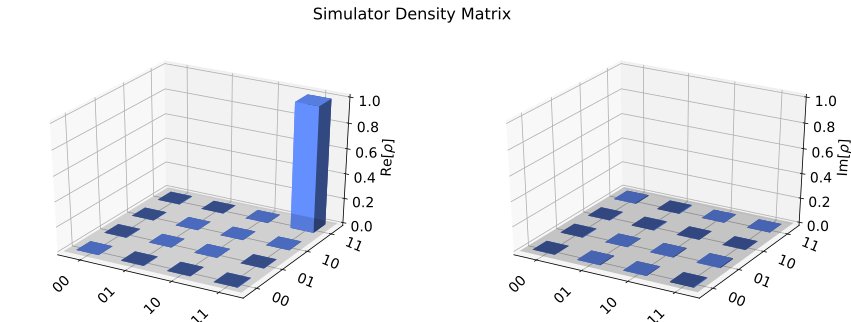

In [8]:
plot_state_city(rho[0], title='Simulator Density Matrix')

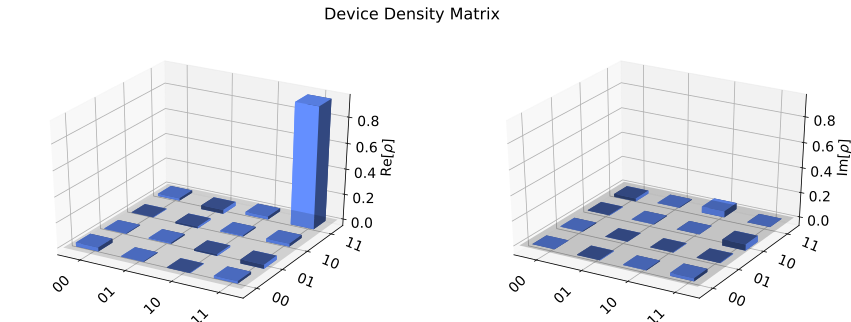

In [9]:
plot_state_city(rho[1], title='Device Density Matrix')

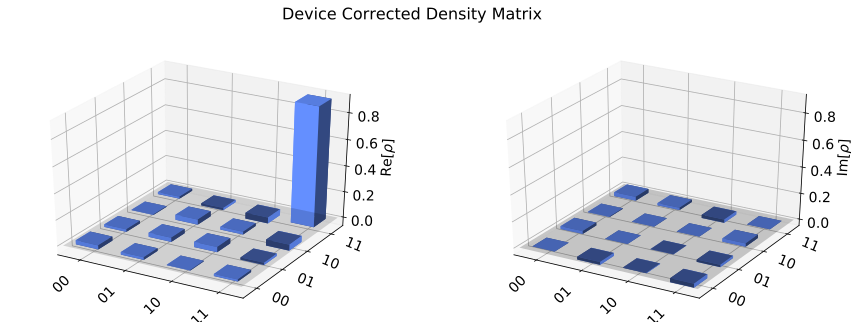

In [10]:
plot_state_city(rho[2], title='Device Corrected Density Matrix')

In [11]:
Sim_Fidelity = state_fidelity(psi_expected, rho[0], validate=False)
Dev_Fidelity = state_fidelity(psi_expected, rho[2], validate=False)
Err_Fidelity = state_fidelity(psi_expected, rho[1], validate=False)
Err_Fidelity2 = state_fidelity(psi_expected, rho[3], validate=False)
print('Simulation Fidelity:', Sim_Fidelity)
print('Corrected Device Fidelity:', Err_Fidelity)
print('Device Fidelity:', Dev_Fidelity)
print('Self Corrected Device Fidelity:', Err_Fidelity2)

Simulation Fidelity: 1.0000000000000004
Corrected Device Fidelity: 0.9505294464494553
Device Fidelity: 0.9138183593750004
Self Corrected Device Fidelity: 0.9610459622457199


In [12]:
rho_sim = DensityMatrix(rho[0])
rho_dev = DensityMatrix(rho[1])
print('Is the simulator density matrix valid?', rho_sim.is_valid())
print('Is the device density matrix valid?', rho_dev.is_valid())

Is the simulator density matrix valid? False
Is the device density matrix valid? False
